In [1]:
from definitions import *

# RegioJet a kapitalismus
### Vojtěch Novotný

V této zápočtové práci se podíváme, jestli se chová RegioJet ke člověku stejně nehledě na to, kterou třídou jede. Tato žlutá firma nabízí ve svých vlacích 4 různé tarify, to jest:

    - Low cost
    - STANDARD
    - Relax
    - Economy
Zároveň se poměrně často stává, že člověkovi přijde pár dní/hodin před jízdou tzv. "důležité upozornění", to může být třeba přesazení z low cost vagónu do economy, častěji jsou to ale méně příjemné oznámení, třeba že nepojede klima, nebo že vám dokonce zrušili vagón a jízdenku si můžete zrušit. V této práci se podíváme na to, jestli tarif jízdenky souvisí s tím, jestli člověku přijde takovéto upozornění. 

## Data
Všechna data mám vlastní, regiojet posílá s každou změnou i jízdenkou email, tak se mi povedlo v mém okruhu přátel nastřádat celkem 289 jízdenek, z toho 80 bylo po zakoupení změněno. Jedná se o převážně jízdenky z Havířova do Prahy. Tarify jsou tam z většiny low cost a standard, nezanedbatelné množství relaxů, ale 0 economy (tam nemají ISIC slevy :( ) 

Všechna data musela být rozparsována z textu emailů a tyto maily **neměly** jednotnou formu. Je tedy možné, že se některé maily naparsovaly špatně a já to neměl jak automaticky zkontrolovat. Výsledky této práce by tedy neměly být brány zcela vážně.

Jedna v větších komplikací byla, které zrušené jízdenky do statistiky počítat. Nejjednodušší odpověď je "žádné", problém ale je v tom, že člověk si často jízdenku zruší právě kvůli tomu, že mu přislo upozornění o změně. Druhá nejjednodušší odpověď je "všechny". To by bylo lepší, ale zase když si člověk plánuje jízdy domů na měsíc dopředu a rozmyslí si vlak, co je 3 týdny daleko, měli bychom ho opravdu počítat jako vlak "bez změny"? Nakonec jsem to vyřešil tak, že jsem počítal jen ty zrušené jízdenky, které byly zrušeny méně než 48h před odjezdem, protože do právě toho intervalu 48h spadala **naprostá většina** změn.

Dále v případě, že se našly 2 jízdenky ve stejný čas a se stejným tarifem, počítal jsem je jen jednou, přičemž jsem náhodně vybral kterou. Vynecháním pár ( pár<10 ) náhodných jízdenek nic nepokazíme, na druhou stranu je nechceme započítávat, protože změny se často dějou rovnou celému vagónu, takže by nám to zkreslilo statistiku (a kontrola přímo shody vagónů dvou jízdenek by výrazně zkomplikovala parsování mailů).
## Matematika


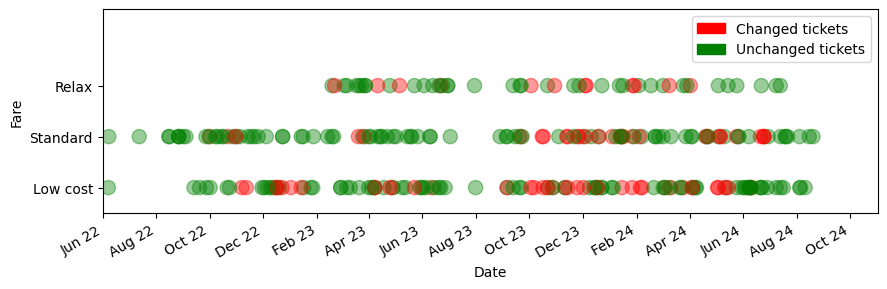

In [2]:
x = [entry[0] for entry in rides]
y = [entry[1] for entry in rides]
color = ["red" if entry[2] else "green" for entry in rides]

fig, ax = plt.subplots(figsize=(10, 3))
ax.legend(handles=[red_patch, green_patch])

plt.xlabel("Date")
plt.ylabel("Fare")
plt.yticks([1, 2, 3], ["Low cost", "Standard", "Relax"])
plt.ylim(0.5, 4.5)
plt.scatter(x, y, s=105, c=color, alpha=0.4)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))  # Format as Year-Month-Day
plt.gcf().autofmt_xdate()

_x = plt.xlim(left=datetime.datetime(2022, 6, 1))
plt.show()


Už "vod voka" jde na grafu vidět, že se dějou 2 věci, což je o 1 více, než jsem předpokládal. Nejen že to vypadá, že má nulová hypotéza by mohla být brzo potvrzena, ale taky to vypadá, že se regiojet s časem docela zhoršil, co se počtu upozornění týče. Podívejme se tedy prvně jestli spolehlivost regiojetu neupadá...

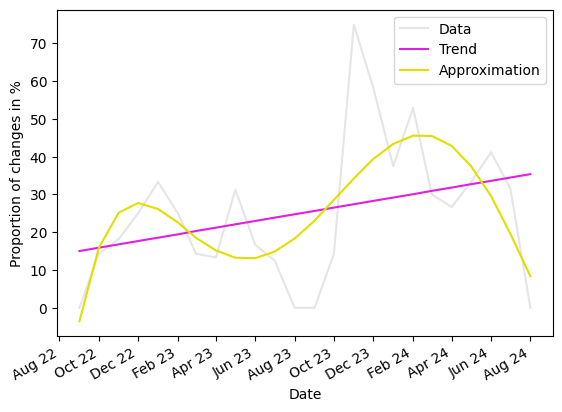

Směrodatná odchylka: 18.61%


In [3]:
starting_month = 9

change_proportions = list(map(lambda x: x * 100, proportion_by_month(rides, starting_month)))

x = range(0, len(change_proportions))
p = np.polyfit(x,change_proportions,5)
poly_y_5 = np.poly1d(p)(x)
p = np.polyfit(x,change_proportions,1)
poly_y_1 = np.poly1d(p)(x)

m_range = month_range(datetime.datetime(2022, starting_month, 1), datetime.datetime(2024, 8, 11)).date

plt.plot(m_range, change_proportions, color='#e5e5e5')
plt.plot(m_range, poly_y_1, color='#df20df')
plt.plot(m_range, poly_y_5, color='#dfdf00')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
plt.gcf().autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Proportion of changes in %')
plt.gca().legend(( 'Data', 'Trend', 'Approximation'))
plt.show()

print("Směrodatná odchylka: " + str(round(standard_deviation(change_proportions), 2)) + "%")


Ačkoliv to vypadá, že časem se počet změn zvyšuje, při jemněší approximaci jde vidět, že počet změn je velice proměnlivý, pravděpodobně závislý na ročním období (to potvrzuje i směrodatná odchylka). Pro přesnější závěr by to chtělo data z delšího časového úseku. Avšak se musíme vrátit k původní otázce, protože proměnlivost dat může být způsobena i proměnlivostí toho, jaké tarify jsme kdy kupovali!

Mějme tedy nulovou hypotézu "RegioJet se chová se k zákazníkům fér nehledě na zakoupený tarif" a pojďme se ji pokusit vyvrátit. Použijeme k tomu *Pearsonův korelační koeficient* a budeme doufat, že bude daleko od 0 a že ```p-value``` se dostane pod **0.05** ...

In [4]:
fares = list(map(lambda r: r[1], rides))
changes = list(map(lambda r: 0 if r[2] else 1, rides))

result = st.pearsonr(fares, changes)

print(f"Pearsonův korelační koeficient: {result.statistic}")
print(f"p-value: {result.pvalue}")

Pearsonův korelační koeficient: 0.07743512902840874
p-value: 0.1892962476716726


p-value je daleko nad 0.05 a nulové hypotéze tedy jsem nucen nadále věřit. Moje poslední záchrana je si ještě ověřit, jestli jsem měl vůbec důvod podezřívat RegioJet ze znevýhodňování chudých, pojďme si tedy ještě spočítat pár základních statistik...

In [5]:
print_change_percentage(fare=1)
print_change_percentage(fare=2)
print_change_percentage(fare=3)
print_change_percentage()



Percentage of changed tickets for fare "low cost": 31.97%
Percentage of changed tickets for fare "standard": 25.0%
Percentage of changed tickets for fare "relax": 23.53%
Percentage of changed tickets: 27.68%


Zajímavé, z těchto výsledků to vypadá, že možná regiojet znevýhodňuje pouze své nejchudší cestující a výše už mezi nimi nerozlišuje! Další nulová hypotéza teda je "RegioJet znevýhodňuje své nejchudší cestující podobně často, jako ty ostatní".

In [6]:
fares = list(map(lambda r: 1 if r[1] == 1 else 2, rides))
changes = list(map(lambda r: 0 if r[2] else 1, rides))

result = st.pearsonr(fares, changes)

print(f"Pearsonův korelační koeficient: {result.statistic}")
print(f"p-value: {result.pvalue}")

Pearsonův korelační koeficient: 0.08186686820264363
p-value: 0.16512606010230005


Rozdíl se stále nezdá být statisticky signifikantní... RegioJet je skvělá firma a všechny své zákazníky znevýhodňuje podobně často


## Čas na p-hacking
Přece nemůžeme práci zakončit neúspěchem, za to nám nikdo nezaplatí! Zkusíme zkusíme experiment opakovat pořád dokola, dokud nám nevyjde hledaná p-value

In [31]:
the_only_pvalue = 1
tries = 0
while(the_only_pvalue > 0.05):
    tries += 1
    fares, changes = get_random_specimen(0.7)

    the_only_pvalue = st.pearsonr(fares, changes).pvalue

print(f"P-value: {the_only_pvalue}")
print(f"Počet pokusů: {tries}")

P-value: 0.022322119132996476
Počet pokusů: 62


To by ale v realitě docela trvalo. Pojďme p-hackovat chytřeji. *Nikdo* se nebude zlobit, když místo 250 vzorků budu mít 150 a stejně nás přece nejvíce zajímá období, kdy se "Důležité upozornění" *opravdu děly*, pojďme tedy naše jízdenky omezit třeba takhle:

In [8]:
fares = list(map(lambda r: r[1], rides))[15:166]
changes = list(map(lambda r: 0 if r[2] else 1, rides))[15:166]

result = st.pearsonr(fares, changes)

print(f"p-value: {result.pvalue}")

p-value: 0.04553573078575935



## Závěr
Tato práce se pokusila dokázat, že RegioJet není fér, avšak se jí to nepovedlo. Percentuálně se sice může zdát, že levnější jízdenky zažívají více změn, není to však statisticky signifikantní rozdíl. Tato práce je hlavně varování před pochybnými články, které své závěry vyvozují pouze z pohledu na graf, a před tím, jak snadný je p-hacking.